In [18]:
%pylab inline

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
#import statsmodels
import statsmodels.api as sm
import scipy as sc
from scipy.stats import binned_statistic_2d, boxcox
from sklearn import datasets, linear_model, metrics
from itertools import product
import statsmodels.formula.api as smf


Populating the interactive namespace from numpy and matplotlib


C:\Users\nlavr\Anaconda2\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Читаем подготовленные данные за период с 2015-02 по 2015-08 для ячейки 1126:

In [269]:
f_data = pd.read_pickle('stat_2015-02_2015-08_1126.dat')
print f_data.shape
f_data.head()

(5088, 3)


,tpep_pickup_datetime,region,count
16,2015-02-01 00:00:00,1126,260.0
254,2015-02-01 01:00:00,1126,193.0
496,2015-02-01 02:00:00,1126,153.0
721,2015-02-01 03:00:00,1126,81.0
943,2015-02-01 04:00:00,1126,65.0


Будем использовать время как индекс:

In [147]:
data = f_data.set_index(f_data['tpep_pickup_datetime'])
#data = data[:(672)]

Исходный ряд:

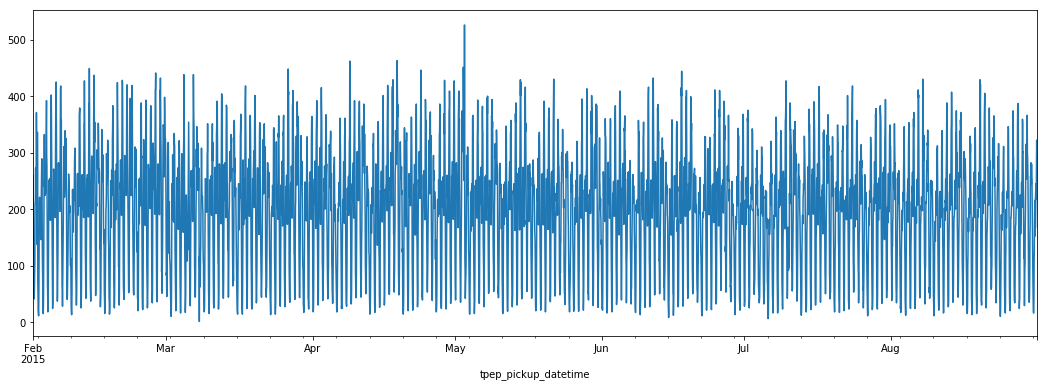

In [148]:
plt.rcParams["figure.figsize"] = (18,6)
data['count'].plot()

Составим признаки для регресии

In [224]:
#Зададим порядковый номер записи
data['rn'] =  range(1, data.shape[0] + 1)

K = 9
for k in range(1, K + 1):
    data.loc[:,'s'+ str(k)] = np.sin(data['rn'] * 2 * np.pi * k / 168)
    data.loc[:,'c'+ str(k)] = np.cos(data['rn'] * 2 * np.pi * k / 168)
data.head()

,tpep_pickup_datetime,region,count,rn,s1,c1,s2,c2,s3,c3,...,s11,c11,s12,c12,s13,c13,s14,c14,s15,c15
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,,,,
2015-02-01 00:00:00,2015-02-01 00:00:00,1126,260.0,1,0.037391,0.999301,0.074730,0.997204,0.111964,0.993712,...,0.399892,0.916562,0.433884,0.900969,0.467269,0.884115,0.500000,8.660254e-01,0.532032,0.846724
2015-02-01 01:00:00,2015-02-01 01:00:00,1126,193.0,2,0.074730,0.997204,0.149042,0.988831,0.222521,0.974928,...,0.733052,0.680173,0.781831,0.623490,0.826239,0.563320,0.866025,5.000000e-01,0.900969,0.433884
2015-02-01 02:00:00,2015-02-01 02:00:00,1126,153.0,3,0.111964,0.993712,0.222521,0.974928,0.330279,0.943883,...,0.943883,0.330279,0.974928,0.222521,0.993712,0.111964,1.000000,6.123234e-17,0.993712,-0.111964
2015-02-01 03:00:00,2015-02-01 03:00:00,1126,81.0,4,0.149042,0.988831,0.294755,0.955573,0.433884,0.900969,...,0.997204,-0.074730,0.974928,-0.222521,0.930874,-0.365341,0.866025,-5.000000e-01,0.781831,-0.623490
2015-02-01 04:00:00,2015-02-01 04:00:00,1126,65.0,5,0.185912,0.982566,0.365341,0.930874,0.532032,0.846724,...,0.884115,-0.467269,0.781831,-0.623490,0.652287,-0.757972,0.500000,-8.660254e-01,0.330279,-0.943883


Сделем регрессию ряда на сгенерированные выше признаки и посмотрим на остатки регресии:

51.4973166266


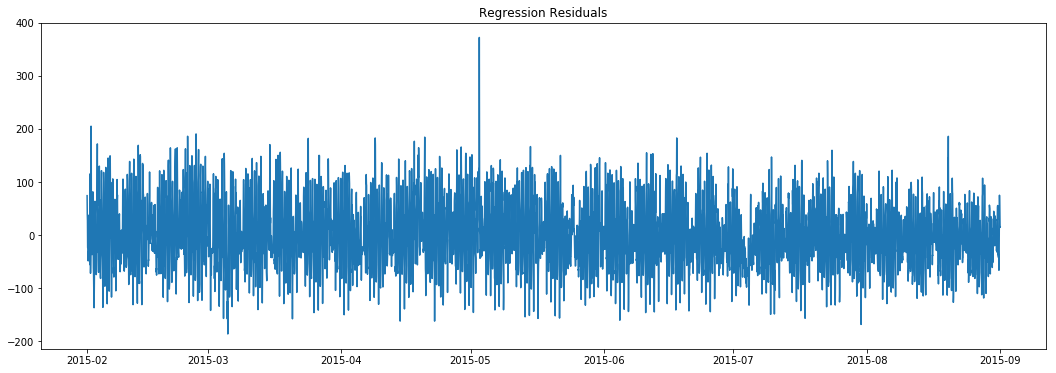

In [225]:
x_names = []
for k in range(1, K + 1):
    x_names.append('s'+ str(k))
    x_names.append('c'+ str(k))

m1 = smf.ols('count ~ ' + str.join(' + ', x_names), 
             data=data)
fitted = m1.fit()
plt.rcParams["figure.figsize"] = (18,6)
plt.title('Regression Residuals')
plt.plot(fitted.resid)

predictions = fitted.predict(data[x_names])
print metrics.mean_absolute_error(data['count'], predictions)

Проверим среднее и критерий Дики-Фуллера для остатков и визуально изучим STL декомпозицию:

-8.04388002747e-15
3.71557794117e-12


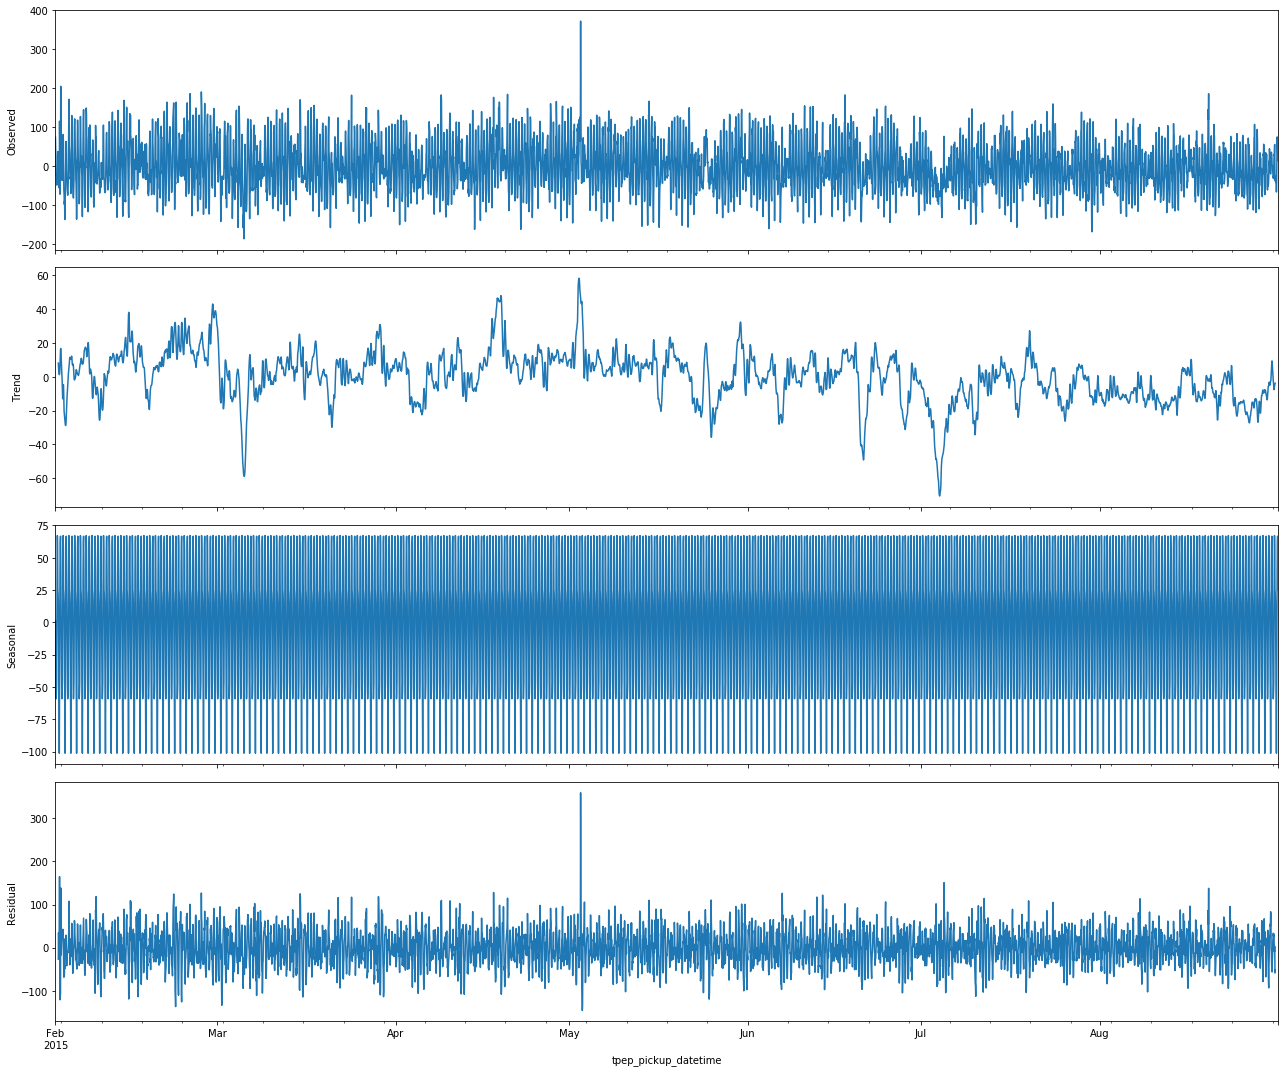

In [226]:
print fitted.resid.mean()
print sm.tsa.stattools.adfuller(fitted.resid)[1]

plt.rcParams["figure.figsize"] = (18,15)
dec = sm.tsa.seasonal_decompose(fitted.resid)
dec.plot()
pylab.show()
#print dec.seasonal[:31].plot()
plt.show()

Критерий Дики-Фуллера отвергает гипотезу о нестационарности, однако визуально видно, изменение тренда. Проведем внутрисуточное дифференцирование (12 часов) т.к. всплески количества поездок случаются дважды в сутки (утро и вечер):

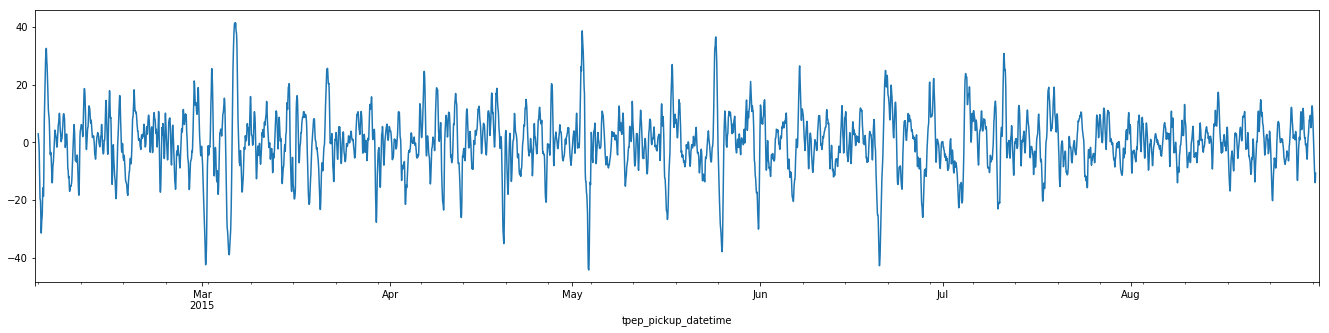

In [234]:
lag = 12
data['resid_diff_24'] = fitted.resid - fitted.resid.shift(lag)
dec = sm.tsa.seasonal_decompose(data['resid_diff_24'][lag:])

plt.rcParams["figure.figsize"] = (23,5)
#dec.plot()
dec.trend.plot()
pylab.show()

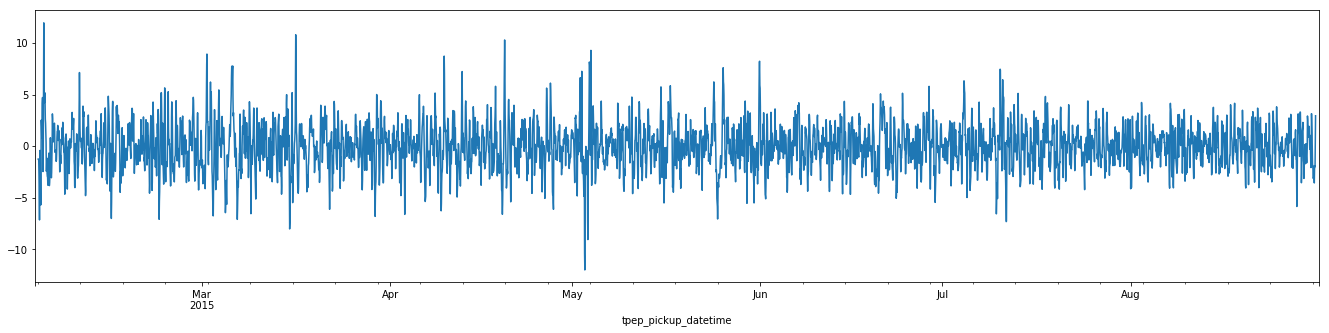

In [235]:
lag2 = 1
data['resid_diff_24_1'] = data['resid_diff_24'] - data['resid_diff_24'].shift(lag2)
dec = sm.tsa.seasonal_decompose(data['resid_diff_24_1'][(lag + lag2):])
plt.rcParams["figure.figsize"] = (23,5)
#dec.plot()
dec.trend.plot()
pylab.show()

Теперь ряд больше похож на стационарный. Посмотрим на ACF и PACF полученного ряда:

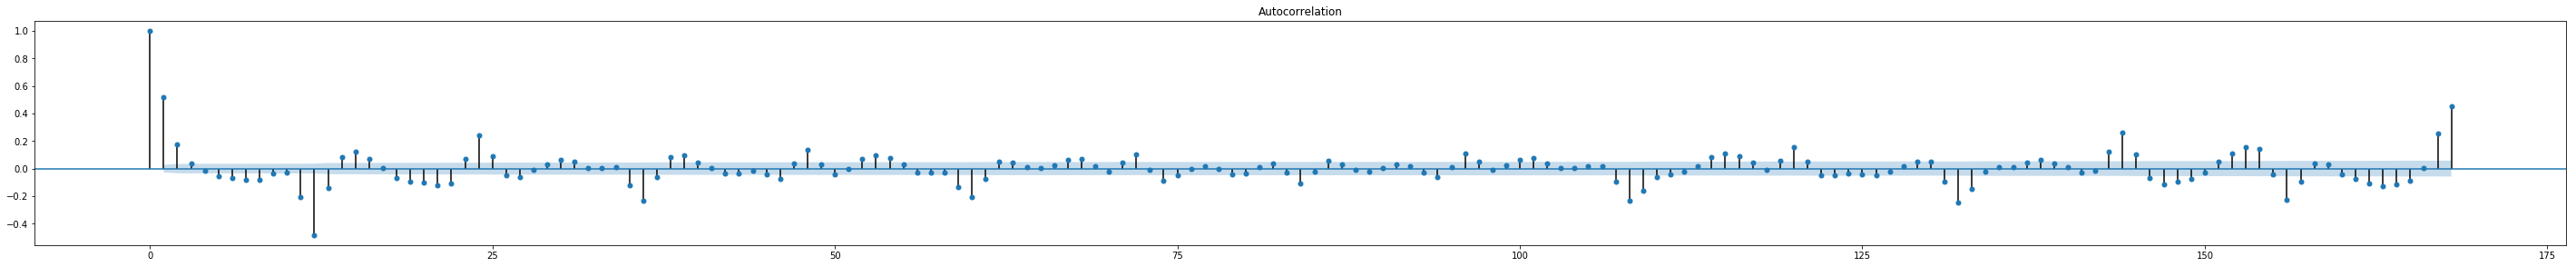

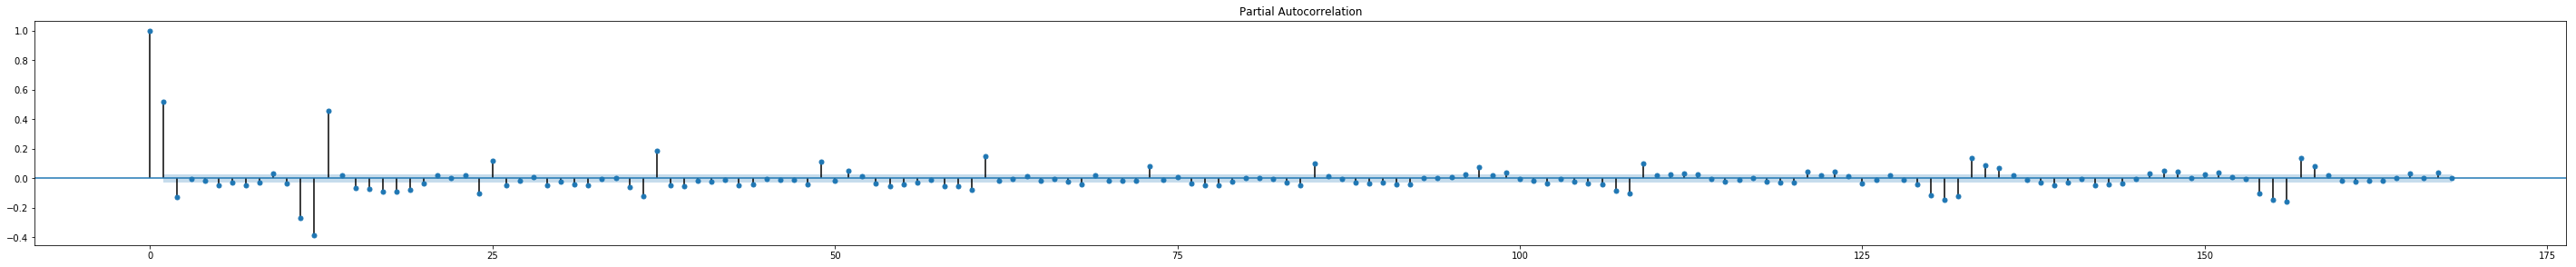

In [236]:
plt.figure(figsize(50,10))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data['resid_diff_24'][(lag + lag2):].values.squeeze(), lags=168, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data['resid_diff_24'][(lag + lag2):].values.squeeze(), lags=168, ax=ax)
pylab.show()

Подберем начальные приближения для параметров модели исходя из ACF и PACF:

In [261]:
Q = 1 
q = 2 
P = 1
p = 2

#Для полного перебора можно раскомментировать строки кода ниже
ps = [2]#range(0, p + 1)
d =  0#Ноль обычных дифференцирований
qs = [1]# range(0, q + 1)
Ps = range(0, P + 1)
D = 1 #Одно сезонное дифференцирование
Qs = [1]#range(0, Q + 1)

In [262]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print len(parameters_list)

2


Подберем модель. Будем использовать признаки регресии как параметр exog:

In [263]:
#%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        print param
        model=sm.tsa.statespace.SARIMAX(data['count'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], lag), exog=data[x_names]).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

(2, 1, 0, 1)
(2, 1, 1, 1)


In [264]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters           aic
0  (2, 1, 0, 1)  49042.580463
1  (2, 1, 1, 1)  49042.685082


Изучим модель с наименьшим AIC:

Критерий Стьюдента: p=0.052750
Критерий Дики-Фуллера: p=0.000000


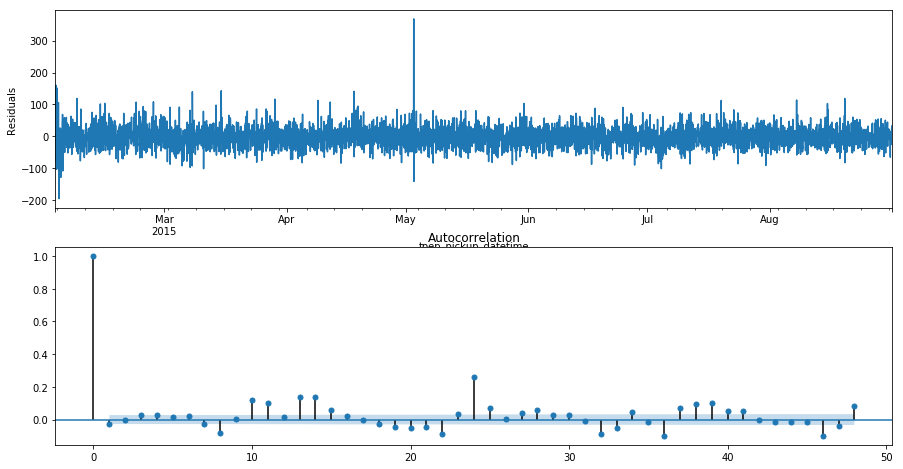

In [265]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % sc.stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально). Однако присутствует некоторая автокореллированность связанная возможно с неполнотой инфорации (признаков) о сезонности.
Посмотрим, насколько хорошо модель описывает данные:

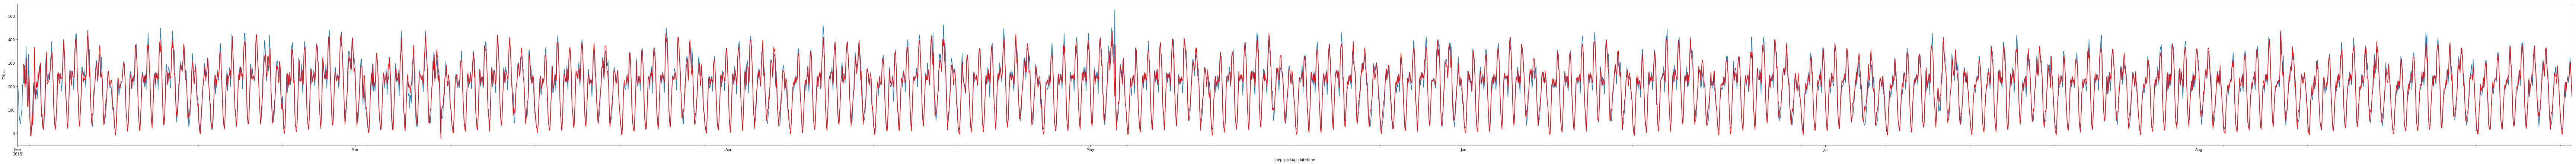

In [268]:
data['model'] = best_model.fittedvalues
plt.figure(figsize(123,7))
data['count'].plot()
data['model'][lag:].plot(color='r')
plt.ylabel('Trips')
pylab.show()

Можно сделать вывод о том что модель неплохо описывает данные, однако можно поработать над улучшение прогнозов внутрисуточной сезонности.
Видно, что модель не очень хорошо прогнозирует значения ряда близкие к средним, они находятся внутри недель(разница между будними и выходными, начало и конец недели).
Как вариант - сгенерировать признаки с для учета внутринедельной сезонности.
Кроме того можно более подробно рассмотреть признаки внутри суток и учесть не только два максимума в течение суток. 
